In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
class MyAutoEncoder(nn.Module):
    def __init__(self, input_size=372, first_compression =256, second_compression = 128, third_compression = 64, activation = nn.ReLU()):
        super(MyAutoEncoder, self).__init__()
        
        self.input_size = input_size
        self.activation = activation
        self.first_compression = first_compression
        self.second_compression = second_compression
        self.third_compression = third_compression

        self.latent_size = input_size # The "bottleneck" size is the same as the input size

        # --- self.encoder: Three layers of size 372 ---
        # The output of the third layer is the 'latent representation'
        self.encoder = nn.Sequential(
            # Layer 1 (Encoder L1)
            nn.Linear(self.input_size, self.first_compression),
            self.activation,
            
            # Layer 2 (Encoder L2)
            nn.Linear(self.first_compression, self.second_compression),
            self.activation,
            
            # Layer 3 (Encoder L3 / Bottleneck Layer)
            nn.Linear(self.second_compression, self.third_compression),
        )
        
        # --- self.decoder: Three layers of size 372 ---
        # It takes the latent representation and reconstructs the input
        self.decoder = nn.Sequential(
            # Layer 4 (Decoder L4)
            nn.Linear(self.third_compression, self.second_compression),
            self.activation,
            
            # Layer 5 (Decoder L5)
            nn.Linear(self.second_compression, self.first_compression),
            self.activation,
            
            # Layer 6 (Decoder L6 / Output Layer)
            nn.Linear(self.first_compression, self.input_size),
            # nn.Sigmoid() # Use Sigmoid if your input (372 bits) is normalized (e.g., between 0 and 1)
        )

    def forward(self, x):
        # Flatten the input if it's not already (e.g., from a batch of images)
        x = x.view(x.size(0), -1)
        
        # Pass through the encoder
        encoded = self.encoder(x)
        
        # Pass through the decoder
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler

# Training function
def train_autoencoder_simple(autoencoder, train_vectors, val_vectors, 
                            epochs=10, batch_size=32, learning_rate=0.001, device='cuda'):
    # Setup device
    if device == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("⚠️  Using CPU")
    
    # Create data loaders
    train_tensor = torch.FloatTensor(train_vectors)
    train_dataset = TensorDataset(train_tensor, train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    if val_vectors is not None:
        val_tensor = torch.FloatTensor(val_vectors)
        val_dataset = TensorDataset(val_tensor, val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Move model to device
    autoencoder = autoencoder.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay = 1e-5)
    
    print(f"\n🚀 Training for {epochs} epochs...")
    train_loss_lst = []
    val_loss_lst = []
    outputs = []
    # Training loop
    for epoch in range(epochs):
        # Train
        autoencoder.train()
        train_loss = 0.0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            encoded, decoded = autoencoder(data)
            loss = criterion(decoded, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_loss_lst.append(avg_train_loss)
        
        # Validate
        if epoch == epochs - 1:
            decoded_test = autoencoder(torch.FloatTensor(val_vectors).to(device))[1].detach().cpu().numpy()


        if val_vectors is not None:
            autoencoder.eval()
            val_loss = 0.0
            
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    encoded, decoded = autoencoder(data)
                    loss = criterion(decoded, target)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_loader)
            val_loss_lst.append(avg_val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1:3d}/{epochs}] | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f}")
        else:
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1:3d}/{epochs}] | Train: {avg_train_loss:.6f}")
    
    print("✅ Training complete!")
    
    outputs.append(decoded_test)
    
    return train_loss_lst, val_loss_lst, outputs

def plot_loss(train_loss, test_loss):
    epochs = range(1, len(train_loss) + 1)
  
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'bo-', label='Train loss')
    plt.plot(epochs, test_loss, 'ro-', label='Test loss')
    plt.title('Training and Testing Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_test_results(test_results, num_encoded_dims):
    test_results = test_results
    num_encoded_dims = num_encoded_dims
    plt.figure(figsize=(10, 6))
    plt.plot(num_encoded_dims, test_results)
    plt.title('KNN Test Results Vs. Encoded Dimensions')
    plt.gca().invert_xaxis() 
    plt.xlabel('Encoded Dimensions')
    plt.ylabel('Success Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


In [0]:
def autoencoder_compression_experiment(autoencoder):
    """
    Test autoencoder compression while maintaining your exact evaluation framework
    """
    print("🧠 AUTOENCODER COMPRESSION EXPERIMENT")
    print("=" * 70)
    
    # Step 1: Load your exact same data
    print("📊 Loading products from the original space")
    gap_df = spark.table("dna_dev.search.enhanced_results_v25_with_mismatch")
    hierarchy_cols = ['division', 'department', 'class', 'subclass']
    
    # Use same sampling as your experiment
    sample_size = 10000
    gap_sample = gap_df.select(hierarchy_cols + ['embeddings']).limit(sample_size).toPandas()
    gap_sample = gap_sample.dropna(subset=['embeddings', 'class'])
    gap_sample = gap_sample[gap_sample['class'].notna()]
    gap_sample['embedding_array'] = gap_sample['embeddings'].apply(np.array)
    
    print(f"📊 Using {len(gap_sample)} products (same as your experiment)")
    
    # Step 2: Prepare vectors and train/test split (identical to your setup)

    train_data, test_data = train_test_split(gap_sample, test_size=0.2, random_state=42)
    train_vectors = np.stack(train_data['embedding_array'].values)
    test_vectors = np.stack(test_data['embedding_array'].values)
    
    print(f"📊 Split: {len(train_data)} train, {len(test_data)} test items")
    
    # Step 3: Test different compression levels
    compression_levels = [372] 
    
    results = {}
    
    for encoding_dim in compression_levels:
        print("-" * 50)
        
        normalized_train = train_vectors
        normalized_test = test_vectors
        
        train_tensor = torch.FloatTensor(normalized_train)
        test_tensor = torch.FloatTensor(normalized_test)
        train_loss, val_loss, outputs = train_autoencoder_simple(
        autoencoder=autoencoder,
        train_vectors=train_tensor,
        val_vectors=test_tensor,
        epochs=100,
        batch_size=64,
        learning_rate=0.0001,
        device='cuda'
            )
            

    return autoencoder,test_vectors, train_loss, val_loss, outputs

    


In [0]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def knn_self_retrieval_test(trained_autoencoder, test_vectors, device='cuda'):
    """
    Test if each embedding can retrieve itself after reconstruction.
    
    The test:
    1. Forward embeddings through the autoencoder
    2. For each reconstructed embedding, find its nearest neighbor in the original inputs
    3. Check if the nearest neighbor is itself (same index)
    4. Score: 1 if success, 0 if failure
    
    Args:
        autoencoder: Trained autoencoder model
        test_vectors: Numpy array of shape (n_samples, embedding_dim)
        device: 'cuda' or 'cpu'
    
    Returns:
        Dictionary with results and statistics
    """
    
    print("=" * 70)
    print("KNN SELF-RETRIEVAL TEST")
    print("=" * 70)
    
    # Setup
    trained_autoencoder.eval()
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    autoencoder = trained_autoencoder.to(device)
    
    n_samples = len(test_vectors)
    print(f"\n📊 Testing {n_samples} samples")
    print(f"📊 Embedding dimension: {test_vectors.shape[1]}")
    
    # Convert to tensor and forward through autoencoder
    test_tensor = torch.FloatTensor(test_vectors).to(device)
    
    print(f"\n🔄 Forwarding through autoencoder...")
    with torch.no_grad():
        encoded, decoded = autoencoder(test_tensor)
    
    # Convert back to numpy
    decoded_np = decoded.cpu().numpy()
    
    # Compute cosine similarity between reconstructed and original embeddings
    # similarity_matrix[i, j] = similarity between reconstructed_i and original_j
    print(f"🔄 Computing similarity matrix...")
    similarity_matrix = cosine_similarity(decoded_np, test_vectors)
    
    # For each reconstructed embedding, find nearest neighbor in original embeddings
    print(f"🔄 Finding nearest neighbors...")
    results = np.zeros(n_samples, dtype=int)
    
    for i in range(n_samples):
        # Get similarities of reconstructed sample i to all original samples
        similarities_for_sample_i = similarity_matrix[i]
        
        # Find the index of the most similar original sample
        nearest_neighbor_index = np.argmax(similarities_for_sample_i)
        
        # Check if it retrieved itself (index matches)
        if nearest_neighbor_index == i:
            results[i] = 1  # Success
        else:
            results[i] = 0  # Failure
    
    # Calculate statistics
    success_count = np.sum(results)
    success_rate = success_count / n_samples
    
    # Calculate average reconstruction quality
    self_similarities = np.array([similarity_matrix[i, i] for i in range(n_samples)])
    avg_self_similarity = np.mean(self_similarities)
    
    # Print results
    print(f"\n" + "=" * 70)
    print("RESULTS")
    print("=" * 70)
    print(f"\n✅ Self-retrieval success: {success_count} / {n_samples} ({success_rate:.2%})")
    print(f"📊 Average cosine similarity (reconstruction): {avg_self_similarity:.4f}")
    
    # Diagnose if results are poor
    if success_rate < 0.5:
        print(f"\n⚠️  WARNING: Low success rate detected!")
        print(f"   This suggests the autoencoder is not reconstructing well.")
        print(f"   Check:")
        print(f"   - Training loss (should be very low for non-compressed AE)")
        print(f"   - Data normalization consistency")
        print(f"   - Model architecture (activation functions, output layer)")
    results = {
        'success_count': success_count,
        'success_rate': success_rate,
        'results': results,
        'avg_self_similarity': avg_self_similarity,
        'similarity_matrix': similarity_matrix,
        'decoded_embeddings': decoded_np
    }
    return results, similarity_matrix

'Testing for 200 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.020867 | Val: 0.020618
Epoch [ 20/100] | Train: 0.015169 | Val: 0.015234
Epoch [ 30/100] | Train: 0.012542 | Val: 0.012786
Epoch [ 40/100] | Train: 0.010960 | Val: 0.011190
Epoch [ 50/100] | Train: 0.009936 | Val: 0.010200
Epoch [ 60/100] | Train: 0.009227 | Val: 0.009539
Epoch [ 70/100] | Train: 0.008655 | Val: 0.008967
Epoch [ 80/100] | Train: 0.008219 | Val: 0.008532
Epoch [ 90/100] | Train: 0.007866 | Val: 0.008195
Epoch [100/100] | Train: 0.007558 | Val: 0.007890
✅ Training complete!


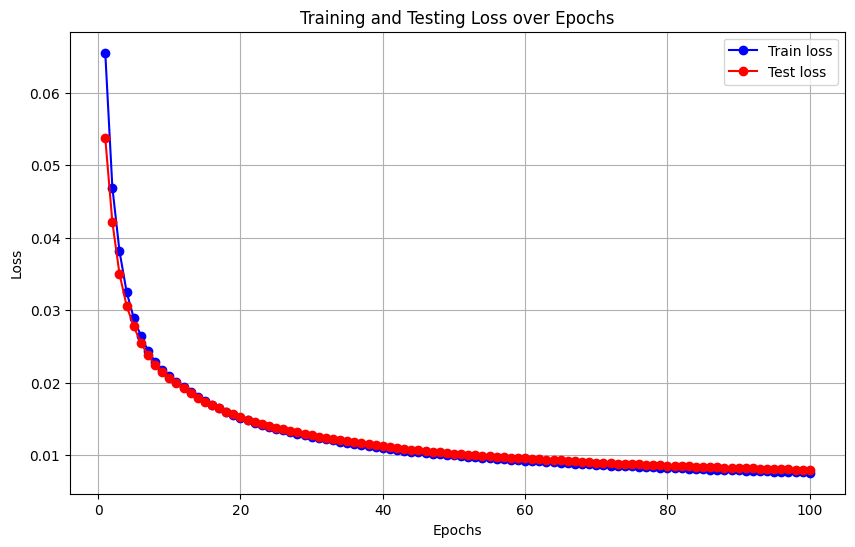

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1971 / 2000 (98.55%)
📊 Average cosine similarity (reconstruction): 0.9509

Final success rate: 98.55%


'Testing for 156 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.021452 | Val: 0.021170
Epoch [ 20/100] | Train: 0.015669 | Val: 0.015724
Epoch [ 30/100] | Train: 0.013069 | Val: 0.013239
Epoch [ 40/100] | Train: 0.011387 | Val: 0.011617
Epoch [ 50/100] | Train: 0.010252 | Val: 0.010523
Epoch [ 60/100] | Train: 0.009448 | Val: 0.009727
Epoch [ 70/100] | Train: 0.008876 | Val: 0.009169
Epoch [ 80/100] | Train: 0.008459 | Val: 0.008800
Epoch [ 90/100] | Train: 0.008127 | Val: 0.008468
Epoch [100/100] | Train: 0.007862 | Val: 0.008249
✅ Training complete!


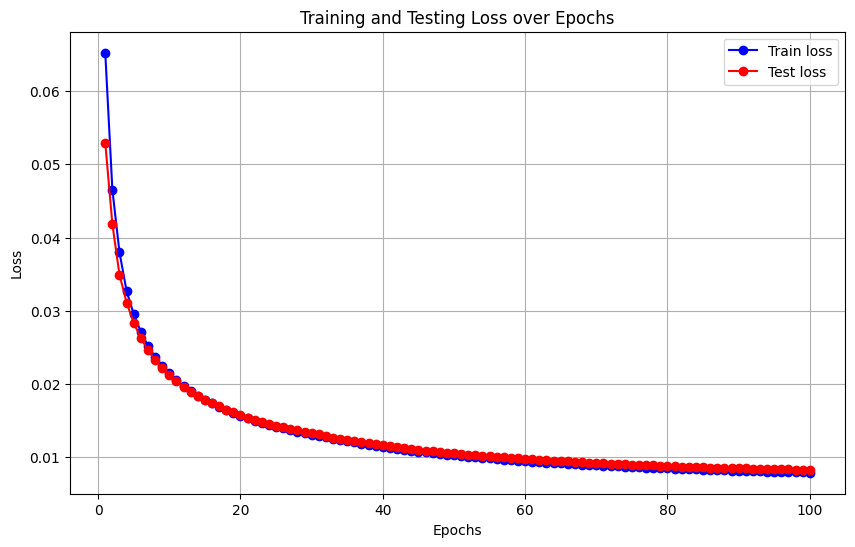

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1976 / 2000 (98.80%)
📊 Average cosine similarity (reconstruction): 0.9488

Final success rate: 98.80%


'Testing for 128 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.023458 | Val: 0.023093
Epoch [ 20/100] | Train: 0.017378 | Val: 0.017381
Epoch [ 30/100] | Train: 0.014697 | Val: 0.014839
Epoch [ 40/100] | Train: 0.013123 | Val: 0.013376
Epoch [ 50/100] | Train: 0.011977 | Val: 0.012224
Epoch [ 60/100] | Train: 0.011081 | Val: 0.011395
Epoch [ 70/100] | Train: 0.010370 | Val: 0.010690
Epoch [ 80/100] | Train: 0.009829 | Val: 0.010159
Epoch [ 90/100] | Train: 0.009398 | Val: 0.009742
Epoch [100/100] | Train: 0.009040 | Val: 0.009424
✅ Training complete!


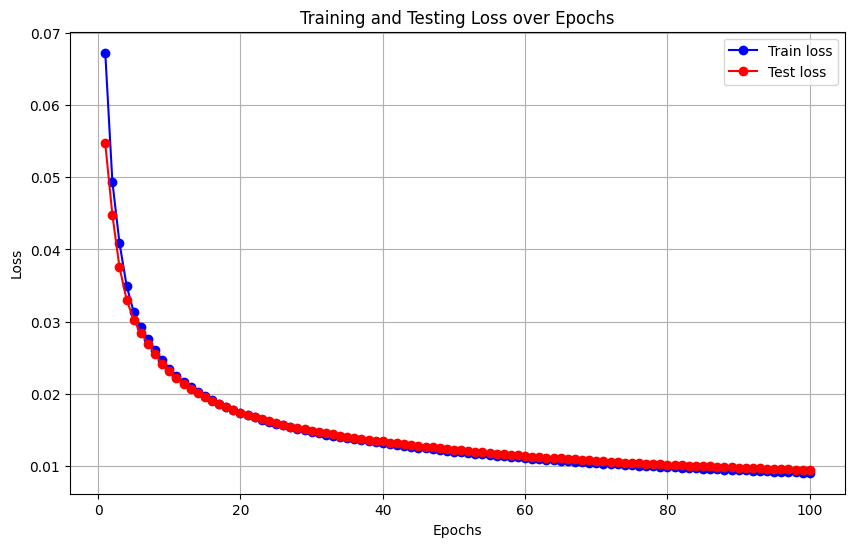

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1966 / 2000 (98.30%)
📊 Average cosine similarity (reconstruction): 0.9414

Final success rate: 98.30%


'Testing for 80 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.025126 | Val: 0.024793
Epoch [ 20/100] | Train: 0.019540 | Val: 0.019531
Epoch [ 30/100] | Train: 0.016678 | Val: 0.016815
Epoch [ 40/100] | Train: 0.014801 | Val: 0.015007
Epoch [ 50/100] | Train: 0.013629 | Val: 0.013930
Epoch [ 60/100] | Train: 0.012834 | Val: 0.013144
Epoch [ 70/100] | Train: 0.012183 | Val: 0.012519
Epoch [ 80/100] | Train: 0.011659 | Val: 0.012034
Epoch [ 90/100] | Train: 0.011213 | Val: 0.011603
Epoch [100/100] | Train: 0.010807 | Val: 0.011186
✅ Training complete!


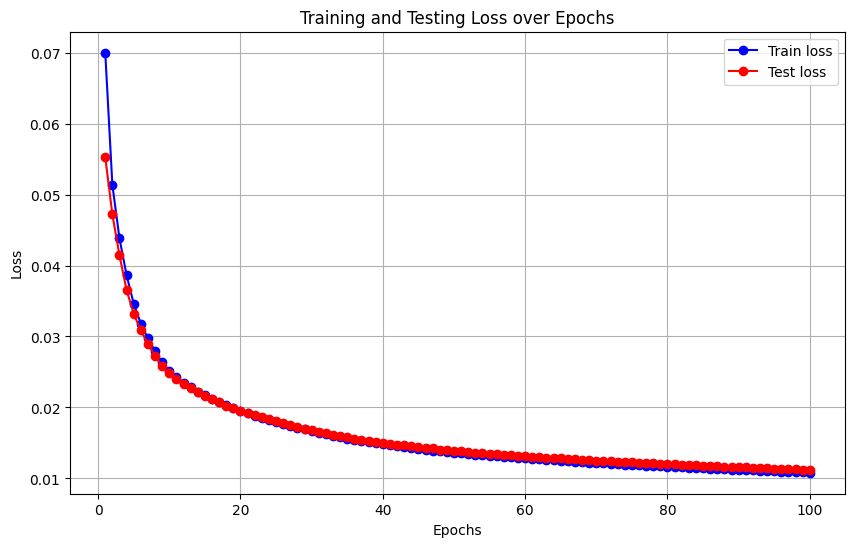

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1922 / 2000 (96.10%)
📊 Average cosine similarity (reconstruction): 0.9300

Final success rate: 96.10%


'Testing for 64 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.025694 | Val: 0.025229
Epoch [ 20/100] | Train: 0.020169 | Val: 0.020163
Epoch [ 30/100] | Train: 0.017504 | Val: 0.017621
Epoch [ 40/100] | Train: 0.015827 | Val: 0.015978
Epoch [ 50/100] | Train: 0.014359 | Val: 0.014573
Epoch [ 60/100] | Train: 0.013414 | Val: 0.013704
Epoch [ 70/100] | Train: 0.012786 | Val: 0.013091
Epoch [ 80/100] | Train: 0.012288 | Val: 0.012634
Epoch [ 90/100] | Train: 0.011891 | Val: 0.012214
Epoch [100/100] | Train: 0.011534 | Val: 0.011872
✅ Training complete!


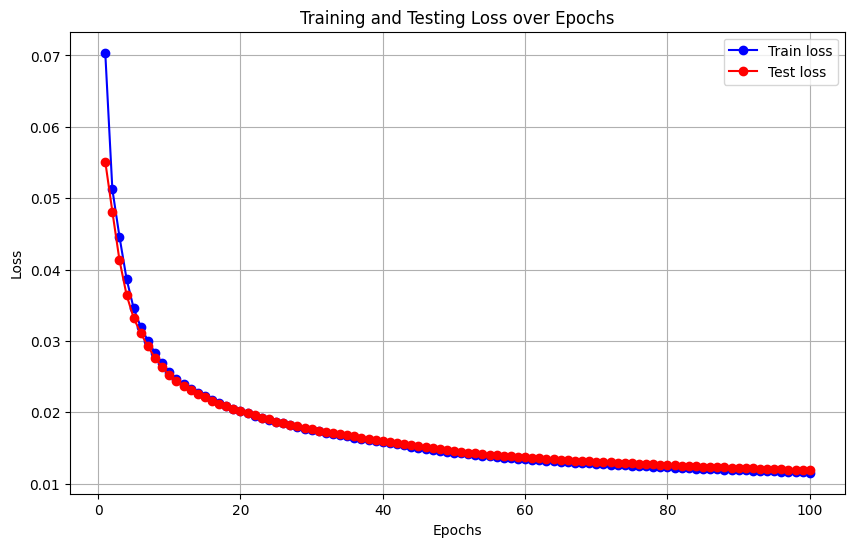

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1886 / 2000 (94.30%)
📊 Average cosine similarity (reconstruction): 0.9256

Final success rate: 94.30%


'Testing for 32 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.026685 | Val: 0.026419
Epoch [ 20/100] | Train: 0.020986 | Val: 0.021018
Epoch [ 30/100] | Train: 0.018342 | Val: 0.018476
Epoch [ 40/100] | Train: 0.016603 | Val: 0.016833
Epoch [ 50/100] | Train: 0.015346 | Val: 0.015536
Epoch [ 60/100] | Train: 0.014513 | Val: 0.014756
Epoch [ 70/100] | Train: 0.013819 | Val: 0.014073
Epoch [ 80/100] | Train: 0.013292 | Val: 0.013575
Epoch [ 90/100] | Train: 0.012863 | Val: 0.013167
Epoch [100/100] | Train: 0.012438 | Val: 0.012792
✅ Training complete!


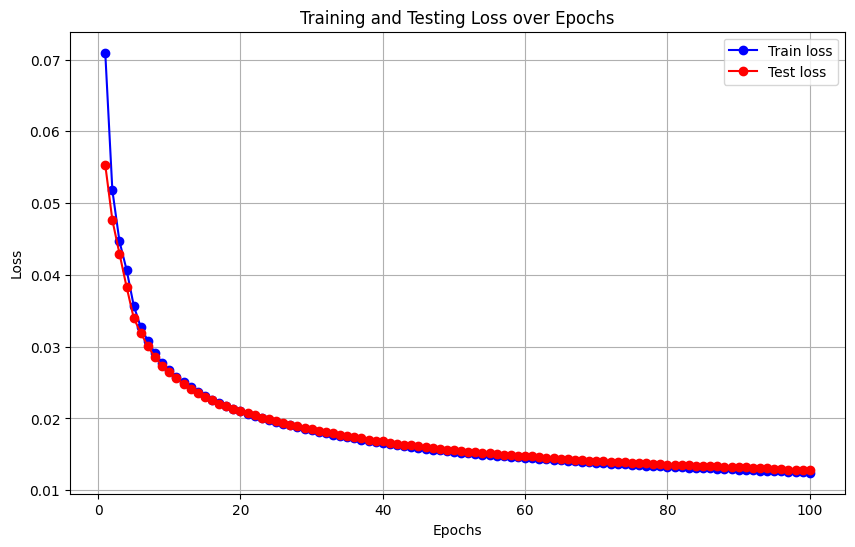

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1857 / 2000 (92.85%)
📊 Average cosine similarity (reconstruction): 0.9196

Final success rate: 92.85%


In [0]:
# Run the experiment
if __name__ == "__main__":
  final_results = []
  MSE_results = []
  num_encoded_dims = [200, 156, 128, 80, 64, 32]
  for num_dims in num_encoded_dims:
    if num_dims == 32:
      autoencoder = MyAutoEncoder( first_compression =256, second_compression = 128, third_compression = 32)
    elif num_dims == 64:
      autoencoder = MyAutoEncoder( first_compression =256, second_compression = 128, third_compression = 64)
    elif num_dims == 80:
      autoencoder = MyAutoEncoder( first_compression =256, second_compression = 156, third_compression = 80)
    elif num_dims == 128:
      autoencoder = MyAutoEncoder( first_compression =286, second_compression = 180, third_compression = 128)
    elif num_dims == 156:
      autoencoder = MyAutoEncoder( first_compression = 320, second_compression = 256, third_compression = 156)
    elif num_dims == 200:
      autoencoder = MyAutoEncoder( first_compression = 340, second_compression = 286, third_compression = 200)
    elif num_dims == 372:
      autoencoder = MyAutoEncoder( first_compression = 372, second_compression = 372, third_compression = 372)
    display(f'Testing for {num_dims} dimensions')
    trained_autoencoder,test_vectors, train_loss, val_loss, outputs = autoencoder_compression_experiment(autoencoder)
    plot_loss(train_loss, val_loss)
    # KNN Test
    results, similarity_matrix = knn_self_retrieval_test(
        trained_autoencoder,
        test_vectors,
        'cuda'
    )
    MSE_results.append(val_loss[-1])
    final_results.append(results['success_rate'])
    print(f"\nFinal success rate: {results['success_rate']:.2%}")
  
      

/root/.ipykernel/2825/command-7414935076479344-3812640152:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


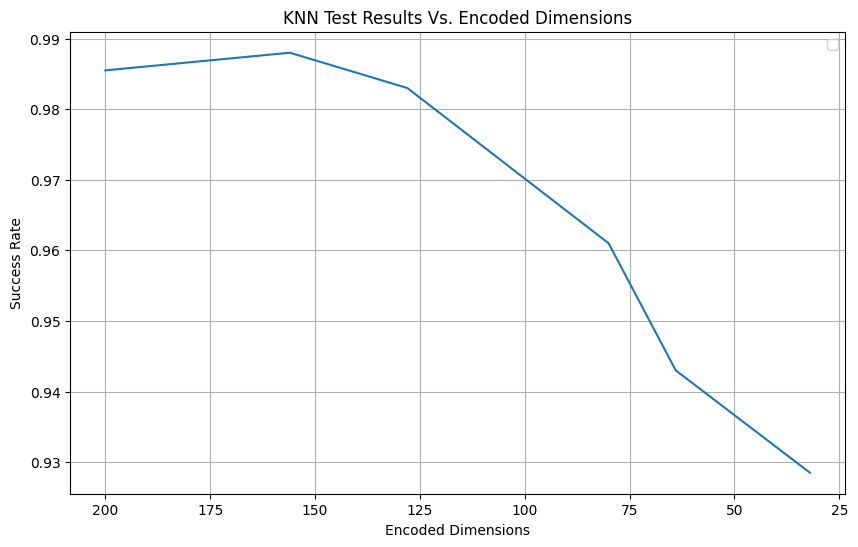

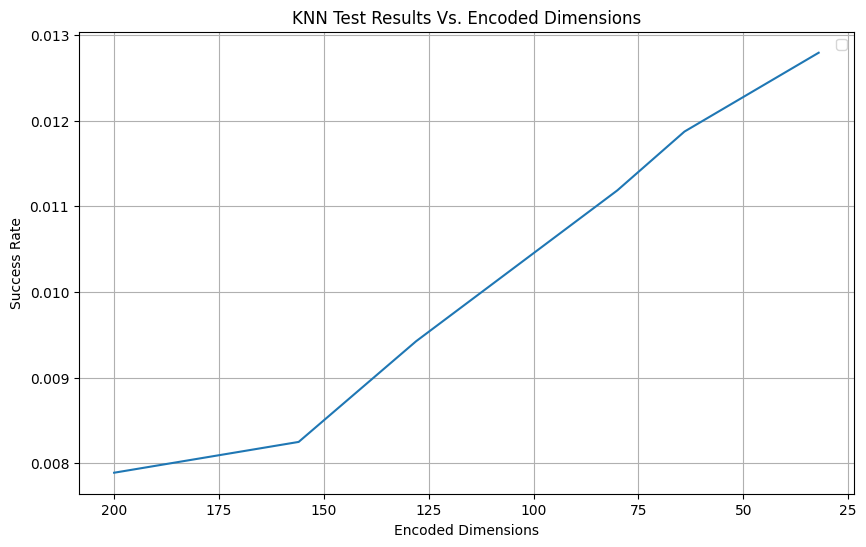

In [0]:
plot_test_results(final_results, num_encoded_dims)
plot_test_results(MSE_results, num_encoded_dims)

# Denoising AutoEncoder

In [0]:
torch.cuda.empty_cache()

In [0]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size=372, first_compression =256, second_compression = 128, third_compression = 64, activation = nn.ReLU()):
        super(DenoisingAutoencoder, self).__init__()
        
        self.input_size = input_size
        self.activation = activation
        self.first_compression = first_compression
        self.second_compression = second_compression
        self.third_compression = third_compression

        self.latent_size = input_size # The "bottleneck" size is the same as the input size

        # --- self.encoder: Three layers of size 372 ---
        # The output of the third layer is the 'latent representation'
        self.encoder = nn.Sequential(
            # Layer 1 (Encoder L1)
            nn.Linear(self.input_size, self.first_compression),
            self.activation,
            
            # Layer 2 (Encoder L2)
            nn.Linear(self.first_compression, self.second_compression),
            self.activation,
            
            # Layer 3 (Encoder L3 / Bottleneck Layer)
            nn.Linear(self.second_compression, self.third_compression),
        )
        
        # --- self.decoder: Three layers of size 372 ---
        # It takes the latent representation and reconstructs the input
        self.decoder = nn.Sequential(
            # Layer 4 (Decoder L4)
            nn.Linear(self.third_compression, self.second_compression),
            self.activation,
            
            # Layer 5 (Decoder L5)
            nn.Linear(self.second_compression, self.first_compression),
            self.activation,
            
            # Layer 6 (Decoder L6 / Output Layer)
            nn.Linear(self.first_compression, self.input_size),
            # nn.Sigmoid() # Use Sigmoid if your input (372 bits) is normalized (e.g., between 0 and 1)
        )

    def forward(self, x):
        # Flatten the input if it's not already (e.g., from a batch of images)
        x = x.view(x.size(0), -1)
        
        # Pass through the encoder
        encoded = self.encoder(x)
        
        # Pass through the decoder
        decoded = self.decoder(encoded)
        
        return encoded, decoded

'Testing for 200 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.020362 | Val: 0.020040
Epoch [ 20/100] | Train: 0.014832 | Val: 0.014885
Epoch [ 30/100] | Train: 0.012392 | Val: 0.012572
Epoch [ 40/100] | Train: 0.010885 | Val: 0.011095
Epoch [ 50/100] | Train: 0.009923 | Val: 0.010155
Epoch [ 60/100] | Train: 0.009286 | Val: 0.009530
Epoch [ 70/100] | Train: 0.008821 | Val: 0.009103
Epoch [ 80/100] | Train: 0.008433 | Val: 0.008742
Epoch [ 90/100] | Train: 0.008114 | Val: 0.008424
Epoch [100/100] | Train: 0.007849 | Val: 0.008192
✅ Training complete!


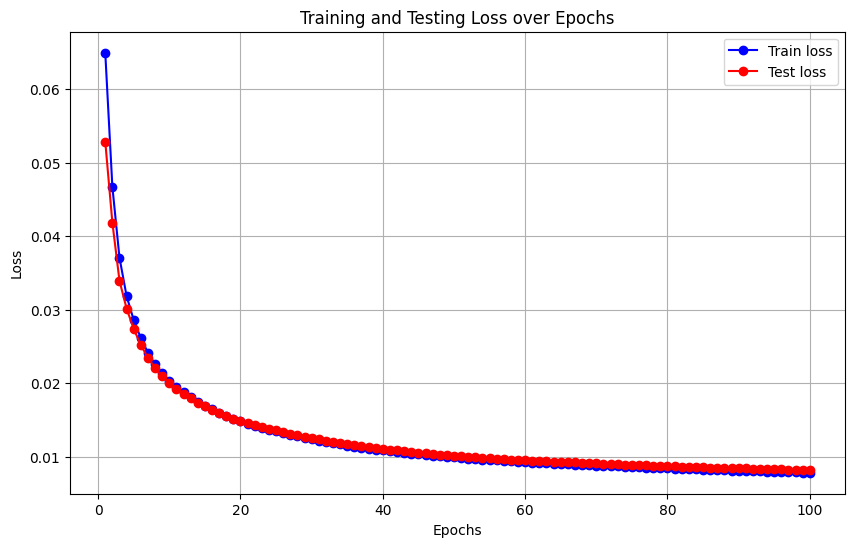

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1968 / 2000 (98.40%)
📊 Average cosine similarity (reconstruction): 0.9491

Final success rate: 98.40%


'Testing for 156 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.022303 | Val: 0.021918
Epoch [ 20/100] | Train: 0.016088 | Val: 0.016107
Epoch [ 30/100] | Train: 0.013479 | Val: 0.013614
Epoch [ 40/100] | Train: 0.011830 | Val: 0.012045
Epoch [ 50/100] | Train: 0.010655 | Val: 0.010906
Epoch [ 60/100] | Train: 0.009913 | Val: 0.010200
Epoch [ 70/100] | Train: 0.009417 | Val: 0.009697
Epoch [ 80/100] | Train: 0.009034 | Val: 0.009321
Epoch [ 90/100] | Train: 0.008718 | Val: 0.009028
Epoch [100/100] | Train: 0.008427 | Val: 0.008750
✅ Training complete!


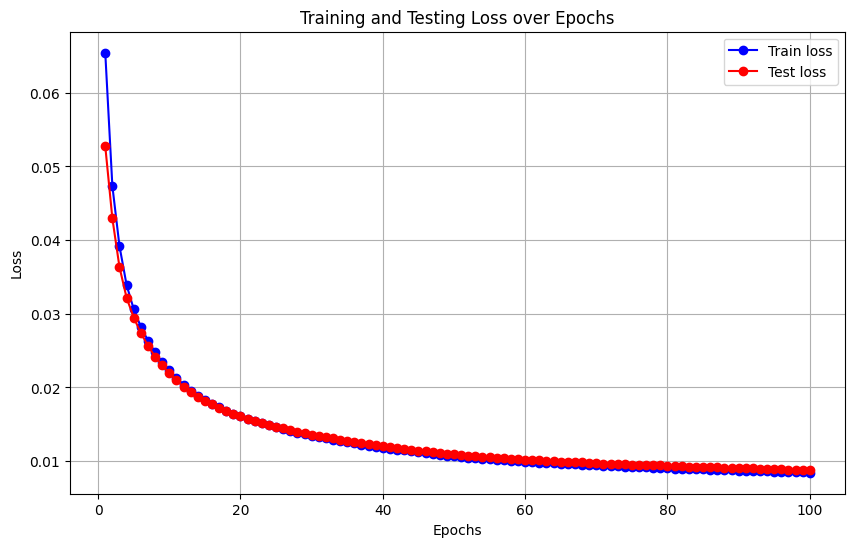

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1972 / 2000 (98.60%)
📊 Average cosine similarity (reconstruction): 0.9456

Final success rate: 98.60%


'Testing for 128 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.024048 | Val: 0.023787
Epoch [ 20/100] | Train: 0.018041 | Val: 0.018156
Epoch [ 30/100] | Train: 0.015086 | Val: 0.015264
Epoch [ 40/100] | Train: 0.013358 | Val: 0.013564
Epoch [ 50/100] | Train: 0.012259 | Val: 0.012495
Epoch [ 60/100] | Train: 0.011366 | Val: 0.011653
Epoch [ 70/100] | Train: 0.010625 | Val: 0.010951
Epoch [ 80/100] | Train: 0.010057 | Val: 0.010392
Epoch [ 90/100] | Train: 0.009605 | Val: 0.009968
Epoch [100/100] | Train: 0.009261 | Val: 0.009664
✅ Training complete!


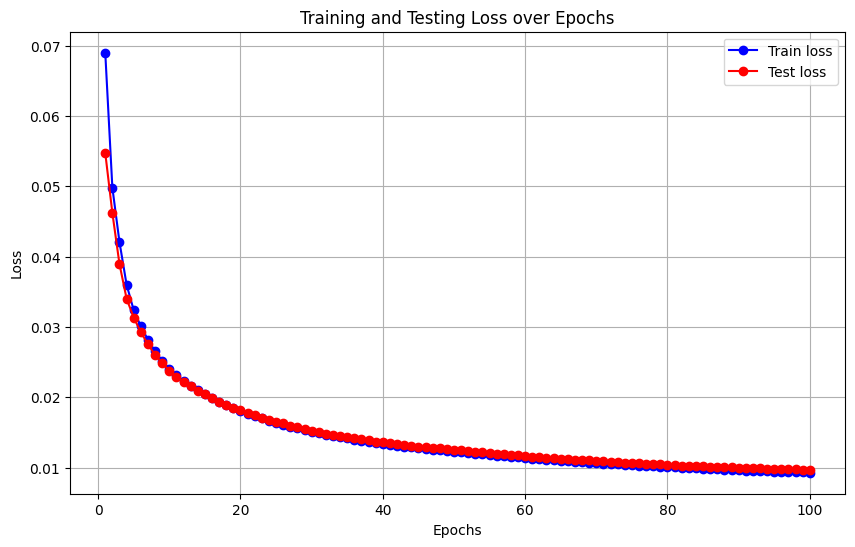

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1962 / 2000 (98.10%)
📊 Average cosine similarity (reconstruction): 0.9399

Final success rate: 98.10%


'Testing for 80 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.025588 | Val: 0.025191
Epoch [ 20/100] | Train: 0.019352 | Val: 0.019330
Epoch [ 30/100] | Train: 0.016278 | Val: 0.016363
Epoch [ 40/100] | Train: 0.014579 | Val: 0.014761
Epoch [ 50/100] | Train: 0.013268 | Val: 0.013512
Epoch [ 60/100] | Train: 0.012330 | Val: 0.012584
Epoch [ 70/100] | Train: 0.011657 | Val: 0.011953
Epoch [ 80/100] | Train: 0.011100 | Val: 0.011425
Epoch [ 90/100] | Train: 0.010666 | Val: 0.011008
Epoch [100/100] | Train: 0.010290 | Val: 0.010634
✅ Training complete!


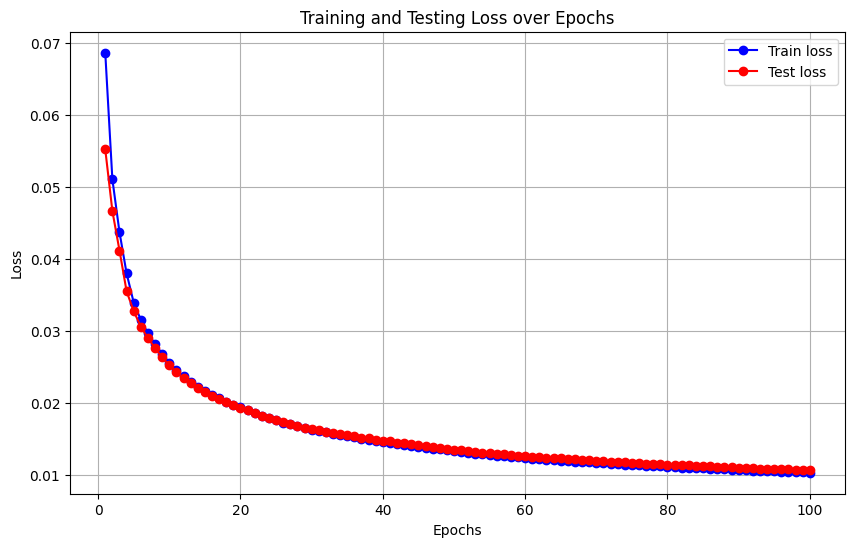

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1938 / 2000 (96.90%)
📊 Average cosine similarity (reconstruction): 0.9335

Final success rate: 96.90%


'Testing for 64 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.025806 | Val: 0.025537
Epoch [ 20/100] | Train: 0.019884 | Val: 0.019871
Epoch [ 30/100] | Train: 0.017047 | Val: 0.017138
Epoch [ 40/100] | Train: 0.015149 | Val: 0.015300
Epoch [ 50/100] | Train: 0.013947 | Val: 0.014126
Epoch [ 60/100] | Train: 0.013065 | Val: 0.013289
Epoch [ 70/100] | Train: 0.012353 | Val: 0.012617
Epoch [ 80/100] | Train: 0.011766 | Val: 0.012045
Epoch [ 90/100] | Train: 0.011277 | Val: 0.011554
Epoch [100/100] | Train: 0.010845 | Val: 0.011135
✅ Training complete!


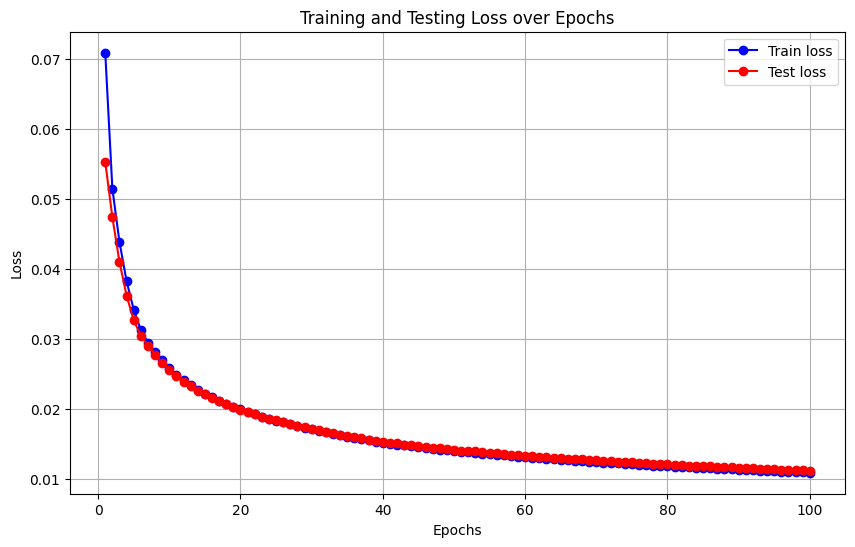

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1925 / 2000 (96.25%)
📊 Average cosine similarity (reconstruction): 0.9303

Final success rate: 96.25%


'Testing for 32 dimensions'

🧠 AUTOENCODER COMPRESSION EXPERIMENT
📊 Loading GAP products from v25...
📊 Using 10000 products (same as your experiment)
📊 Split: 8000 train, 2000 test items
--------------------------------------------------
✅ Using GPU: NVIDIA A10-24Q

🚀 Training for 100 epochs...
Epoch [ 10/100] | Train: 0.026567 | Val: 0.026115
Epoch [ 20/100] | Train: 0.020956 | Val: 0.020936
Epoch [ 30/100] | Train: 0.018250 | Val: 0.018367
Epoch [ 40/100] | Train: 0.016559 | Val: 0.016766
Epoch [ 50/100] | Train: 0.015567 | Val: 0.015857
Epoch [ 60/100] | Train: 0.014804 | Val: 0.015159
Epoch [ 70/100] | Train: 0.014156 | Val: 0.014500
Epoch [ 80/100] | Train: 0.013676 | Val: 0.014071
Epoch [ 90/100] | Train: 0.013292 | Val: 0.013692
Epoch [100/100] | Train: 0.012955 | Val: 0.013403
✅ Training complete!


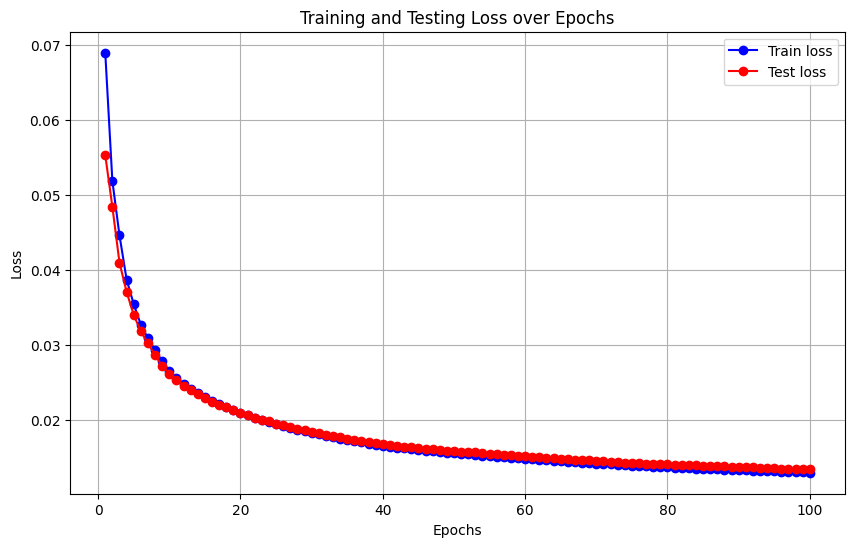

KNN SELF-RETRIEVAL TEST

📊 Testing 2000 samples
📊 Embedding dimension: 372

🔄 Forwarding through autoencoder...
🔄 Computing similarity matrix...
🔄 Finding nearest neighbors...

RESULTS

✅ Self-retrieval success: 1806 / 2000 (90.30%)
📊 Average cosine similarity (reconstruction): 0.9156

Final success rate: 90.30%


In [0]:
# Run the experiment
if __name__ == "__main__":
  final_results = []
  MSE_results = []
  num_encoded_dims = [200, 156, 128, 80, 64, 32]
  for num_dims in num_encoded_dims:
    if num_dims == 32:
      autoencoder = DenoisingAutoencoder( first_compression =256, second_compression = 128, third_compression = 32)
    elif num_dims == 64:
      autoencoder = DenoisingAutoencoder( first_compression =256, second_compression = 128, third_compression = 64)
    elif num_dims == 80:
      autoencoder = DenoisingAutoencoder( first_compression =256, second_compression = 156, third_compression = 80)
    elif num_dims == 128:
      autoencoder = DenoisingAutoencoder( first_compression =286, second_compression = 180, third_compression = 128)
    elif num_dims == 156:
      autoencoder = DenoisingAutoencoder( first_compression = 320, second_compression = 256, third_compression = 156)
    elif num_dims == 200:
      autoencoder = DenoisingAutoencoder( first_compression = 340, second_compression = 286, third_compression = 200)
    display(f'Testing for {num_dims} dimensions')
    trained_autoencoder,test_vectors, train_loss, val_loss, outputs = autoencoder_compression_experiment(autoencoder)
    plot_loss(train_loss, val_loss)
    # KNN Test
    results, similarity_matrix = knn_self_retrieval_test(
        trained_autoencoder,
        test_vectors,
        'cuda'
    )
    MSE_results.append(val_loss[-1])
    final_results.append(results['success_rate'])
    print(f"\nFinal success rate: {results['success_rate']:.2%}")